In [ ]:
import tensorflow as tf
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from transformers import TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,InputLayer, Dropout,GlobalAveragePooling2D, Flatten,Conv2D,MaxPooling2D,BatchNormalization,Layer,Input,Rescaling
# from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
# import sklearn
# from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.metrics import SparseCategoricalAccuracy,SparseTopKCategoricalAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,Permute,InputLayer, Dropout, Flatten,Conv2D,MaxPooling2D,BatchNormalization,Layer,
                                     Input, RandomRotation,RandomFlip, Resizing,Rescaling)
from keras.models import Model
from tensorflow.keras.metrics import  BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
# from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
# import tensorflow_probability as tfp
from tensorflow.keras.callbacks import Callback, TensorBoard,CSVLogger, EarlyStopping, LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
import sklearn
# from sklearn.metrics import confusion_matrix, roc_curve
# import seaborn as sns
import cv2
import imghdr
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPooling2D,BatchNormalization,InputLayer
from keras.models import Model
# from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, 
                             # accuracy_score)

In [ ]:
tf.keras.backend.clear_session()


In [2]:
data_dir_train="C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/SkinDisease/SkinDisease/train"
data_dir_test="C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/SkinDisease/SkinDisease/test"

In [3]:
# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs Available: {gpus}")
    tf.config.experimental.set_memory_growth(gpus[0], True)  # Avoid memory overflow

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
train_data=tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
)

Found 13898 files belonging to 22 classes.


In [5]:
class_names = train_data.class_names
class_names

['Acne',
 'Actinic_Keratosis',
 'Benign_tumors',
 'Bullous',
 'Candidiasis',
 'DrugEruption',
 'Eczema',
 'Infestations_Bites',
 'Lichen',
 'Lupus',
 'Moles',
 'Psoriasis',
 'Rosacea',
 'Seborrh_Keratoses',
 'SkinCancer',
 'Sun_Sunlight_Damage',
 'Tinea',
 'Unknown_Normal',
 'Vascular_Tumors',
 'Vasculitis',
 'Vitiligo',
 'Warts']

In [6]:
test_data=tf.keras.utils.image_dataset_from_directory(data_dir_test)

Found 1546 files belonging to 22 classes.


In [7]:
train_data_itr = train_data.as_numpy_iterator()
batch = train_data_itr.next()
print("Batch Length:", len(batch))
print("Image Batch Shape:", batch[0].shape)
print("Labels:", batch[1])

Batch Length: 2
Image Batch Shape: (32, 256, 256, 3)
Labels: [ 1  2  1 15  2 11  2 20 21  4  5  2 11 21  9 17  2 11 14 11  7 11 20 20
 14 21  2 17  2 20 16 16]


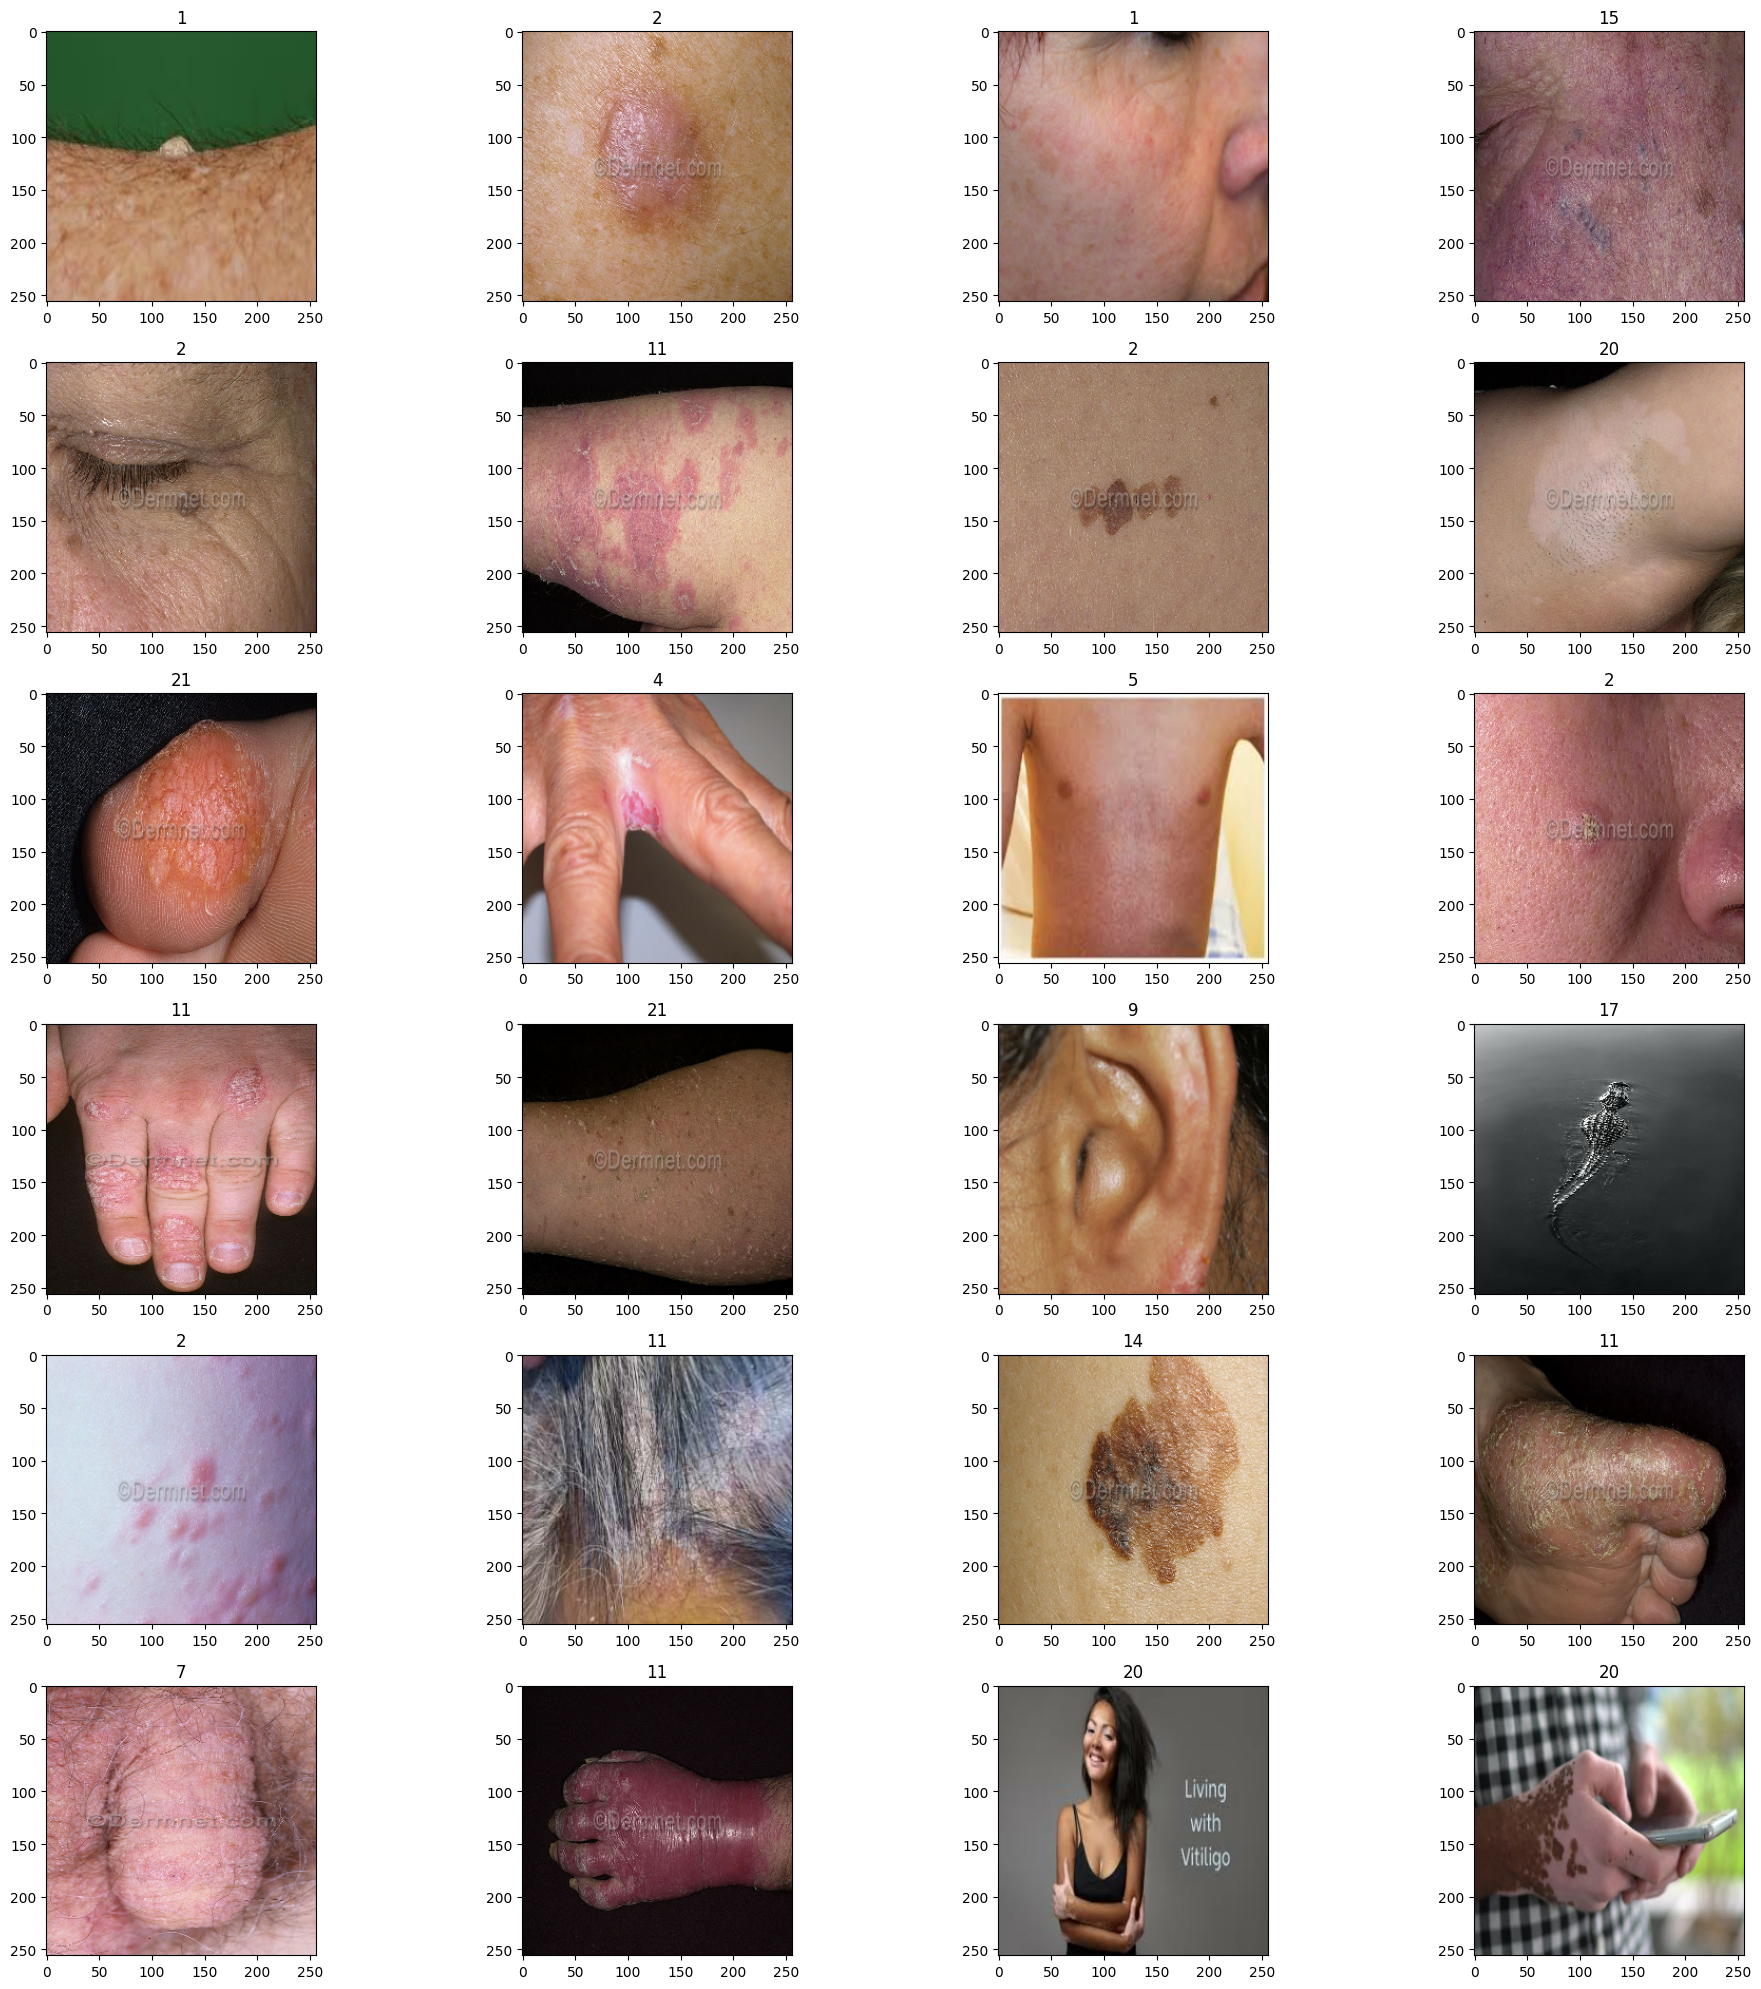

In [8]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))

for idx, img in enumerate(batch[0][:24]):
    row = idx // 4
    col = idx % 4
    ax[row, col].imshow(img.astype(int))
    ax[row, col].title.set_text(str(batch[1][idx]))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [9]:
train_dataset = train_data.prefetch(tf.data.AUTOTUNE)
val_dataset = test_data.prefetch(tf.data.AUTOTUNE)

In [10]:
resize_rescale_hf = tf.keras.Sequential([
    Resizing(224, 224),
    Rescaling(1./255),  # Fixed Rescaling Factor
    Permute((3, 1, 2))
])

In [11]:
# Load Vision Transformer (ViT) from TensorFlow
from transformers import TFAutoModel

vit_model = TFAutoModel.from_pretrained("google/vit-base-patch16-224")

c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Failed to import transformers.models.vit.modeling_tf_vit because of the following error (look up to see its traceback):
Another metric with the same name already exists.

In [ ]:
# Freeze base ViT model
vit_model.trainable = False 

In [ ]:
inputs = Input(shape=(256, 256, 3))

x = resize_rescale_hf(inputs)
x = vit_model(x, training=False)  # Use pretrained ViT features
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation="softmax")(x)  # Adjust output layer

In [ ]:
hf_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
hf_model.compile(optimizer=Adam(learning_rate=5e-5), 
                 loss=tf.losses.SparseCategoricalCrossentropy(), 
                 metrics=[SparseCategoricalAccuracy(name="accuracy"), 
                          SparseTopKCategoricalAccuracy(k=3, name="top_3_accuracy")])

hf_model.summary()

In [ ]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.001,
    cooldown=0,
    min_lr=0,
)

In [ ]:
vit_history = hf_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1,
    callbacks=[plateau_callback]
)
# val_accuracy can reach upto approx 78%-80% by increasing number of epochs and changing learning rate.

In [ ]:
plt.plot(vit_history.history['loss'])
plt.plot(vit_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

In [ ]:
plt.plot(vit_history.history['accuracy'])
plt.plot(vit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()